# Churn Case

Always start your code with the **import of the needed packages**. We already gave the ones we used, so that you wouldn't have to do this anymore as well as that you have some hints about what type of syntax to use.

In [1]:
# import the required packages
import pandas as pd 
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, confusion_matrix

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# 1. Data Exploration

This part reads in the data as well as does some small exploration. But feel free to do some further exploration.

In [2]:
# import all the datasets
extrel = pd.read_csv("./data/extrel.csv")
extrelty = pd.read_csv("./data/extrelty.csv")
communication = pd.read_csv("./data/communication.csv")
payhistory = pd.read_csv("./data/payhistory.csv")
nameaddr = pd.read_csv("./data/nameaddr.csv")
comclas = pd.read_csv("./data/comclas.csv")
commediu = pd.read_csv("./data/commediu.csv")

In [3]:
extrel['EXRELDATEN'] = pd.to_datetime(extrel['EXRELDATEN'], format="%Y-%m-%d")
print(extrel['EXRELDATEN'].max())

extrel['EXTRELSTDT'] = pd.to_datetime(extrel['EXTRELSTDT'], format="%Y-%m-%d")
print(extrel['EXTRELSTDT'].max())

2040-10-27 00:00:00
2020-01-29 00:00:00


In [4]:
# inspect first observation extrel
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


In [5]:
# inspect dtypes of columns
extrel.dtypes

EXTRELNO               int64
EXRELACTCD            object
EXTRELSTDT    datetime64[ns]
EXRELDATEN    datetime64[ns]
dtype: object

In [6]:
## Missing Values
## Categories
## Duplicates
## ..

## 2. Time Window

Let's first define the time window by storing all the **relevant dates** as datetime objects.

In [7]:
# First, define the purpose model.
# The model will be used to predict customers' churn using today's data: END INDEPENDENT: October 26, 2022
# Churn is approximated over 1 year starting from january next year

# Purpose Model

#------------INDEPENDENT----------|xxxxGAPxxxxxx|------DEPENDENT-------|
#                            26/10/2022    01/01/2023             31/12/2023

# Next, we can define the model building part of the timewindow based on the purpose model.
# Data is available until March 2, 2020 (i.e. data dump received).
# End Dep period purpose model <= Available data (Your dependent period needs data input to be able to train a model)
# 31/12/?? <= 02/03/2020         Thus, this becomes: 31/12/2019

# Model Building
#
#------------INDEPENDENT----------|xxxxGAPxxxxxx|------DEPENDENT-------|
#                            26/10/2018    01/01/2019             31/12/2019

# define the model building time window
end_independent = datetime.strptime('26/10/2018', '%d/%m/%Y')
start_dependent = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_dependent = datetime.strptime('31/12/2019', '%d/%m/%Y')

# 3. Data Preparation

## 3.1. Customers

Subset the **extrel** dataset according to the appropriate time window. Remember, we are trying to predict which donors will churn. This means that we are not interested in donors who already left or who are no donors yet. Thus, take into account the following:

    a.	The start of the relationship should be before (or equal to) the end of the independent period.
    b.	The end of the relationship should be later than the start of the dependent period (or missing)

In [8]:
# first change EXTRELSTDT & EXRELDATEN to date type
extrel['EXTRELSTDT'] = pd.to_datetime(extrel['EXTRELSTDT'], format="%Y-%m-%d")
extrel['EXRELDATEN'] = pd.to_datetime(extrel['EXRELDATEN'], format="%Y-%m-%d")

In [9]:
# check
extrel.dtypes

EXTRELNO               int64
EXRELACTCD            object
EXTRELSTDT    datetime64[ns]
EXRELDATEN    datetime64[ns]
dtype: object

In [10]:
# subset according to time window
customers = extrel[(extrel['EXTRELSTDT'] <= end_independent) 
                   & ((extrel['EXRELDATEN'] > start_dependent) | (extrel["EXRELDATEN"].isnull()))]

It's important to also account for the customers that didn't terminate the relationship by *extrel["EXRELDATEN"].isnull()*, otherwise we would only have eventual (partial) churners in our data set.

In [11]:
# check
customers.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT
5,26431,FP,2005-02-26,NaT


In [12]:
type(customers)

pandas.core.frame.DataFrame

In [13]:
# sort by EXTRELNO (= donor ID)
customers = customers.sort_values(by=["EXTRELNO"])

## 3.2. Independent Variables

### 3.2.1. Independent information

Create the following **independent variables**. People with similar features are assumed to show similar behavior. Different kinds of features are used. In classical churn models, there are two main types of features: behavioral features and demographics. **Three predictors** have shown to be key in predicting customer churn in previous work: recency, frequency and monetary value. When we think back at our purpose model, we can only use information that is available at the end of our independent period. Therefore, make sure you use only information available at the end of the independent period :
 
     a.	Frequency: how often a donor has donated during the independent period.
     b.	Recency: time (in days) since the last donation
     c.	Total and average donation per donor (monetary value)
     d.	Paytype per customer
                Create new variables that signify whether a donor ever used sendout, order, own initiative and unknown
     e.	Preferred mailing language
     f.	Dummy whether the donor ever uttered a complaint (CLASCODE)
     g.	Dummy whether communication direction was ever incoming (CONTDIREC)


For creating the independent variables such as recency, frequency, monetary value etc, we first need to make sure that we will only use information **during the independent period**.

In [14]:
# show transaction data set (PAYHISTORY)
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [15]:
# convert PDATE to datetime object
payhistory["PDATE"] = pd.to_datetime(payhistory["PDATE"], format='%Y-%m-%d')

In [16]:
# extract only those transactions which were made before the end of the independent period
payhistory_ind = payhistory[payhistory["PDATE"] <= end_independent]

In [17]:
# sort transactions by extrelno and pdate
payhistory_ind = payhistory_ind.sort_values(by=["EXTRELNO", "PDATE"])

In [18]:
# check
payhistory_ind.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


Now do the same for the **communication** data set.

In [19]:
# convert communication CONTDATE to datetime
communication["CONTDATE"] = pd.to_datetime(communication["CONTDATE"], format='%Y-%m-%d')

In [20]:
# extract only those transactions which were made before the end of the independent period
communication_ind = communication[communication["CONTDATE"] <= end_independent]

In [21]:
# sort transactions by extrelno and contdate
communication_ind = communication_ind.sort_values(by=["EXTRELNO", "CONTDATE"])

In [22]:
# check
communication_ind.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


### 3.2.2. Frequency

**Frequency**: the number of transactions made by a customer during the independent period

In [23]:
# get the frequency: the number of transactions per customer
frequency = payhistory_ind["EXTRELNO"].value_counts().reset_index()
frequency.columns = ["EXTRELNO", "frequency"]

# reset_index() ensures that the value_counts() output is data frame

In [24]:
# check
frequency.head()

,EXTRELNO,frequency
0,1773,2557
1,35231,1360
2,34337,853
3,202611,841
4,2980,586


### 3.2.3. Recency

**Recency**: the number of days between a customer's last transaction and the end of the independent period

In [25]:
# get the recency: time (in days) between last transaction and the end of the independent period
payhistory_ind["time_since_purchase"] = end_independent - payhistory_ind["PDATE"]

In [26]:
# check
payhistory_ind

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS,time_since_purchase
0,38,2006-12-28,9.57,19,X,CO,4320 days
1,39,2006-12-28,41.32,20,X,CO,4320 days
2,40,2006-12-28,13.10,20,X,CO,4320 days
3,54091,2006-12-29,2.02,20,X,CO,4319 days
4,104480,2007-05-16,0.50,20,D,OK,4181 days
...,...,...,...,...,...,...,...
1202650,4658752,2018-10-25,69.00,240058,E,OK,1 days
1202679,4634918,2018-10-14,23.00,240067,E,OK,12 days
1202710,4658895,2018-10-25,23.00,240111,E,OK,1 days
1202726,4358860,2018-01-09,-30.00,240120,D,RF,290 days


In [27]:
# sort according to EXTRELNO and PDATE and drop duplicates
recency = payhistory_ind.sort_values(['EXTRELNO','PDATE'], ascending = [True, False]).drop_duplicates(['EXTRELNO'])

# subset
recency = recency[['EXTRELNO', 'time_since_purchase']]

In [28]:
# check top 5
recency.head()

,EXTRELNO,time_since_purchase
0,19,4320 days
143,20,11 days
298,35,11 days
398,42,1740 days
626,43,838 days


In [29]:
# check bottom 5
recency.tail()

,EXTRELNO,time_since_purchase
1202650,240058,1 days
1202679,240067,12 days
1202710,240111,1 days
1202726,240120,290 days
1202729,240130,5 days


### 3.2.4. Monetary Value

**Monetary value**: the average and total amount of transactions made by a customer during the independent period

In [30]:
# get monetary value: total_value and average_value
monetary_value = payhistory_ind.groupby('EXTRELNO')['PAMT'].agg(['sum','mean']).reset_index()
monetary_value.columns = ["EXTRELNO", "total_value", "average_value"]

In [31]:
# check
monetary_value.head()

,EXTRELNO,total_value,average_value
0,19,9.57,9.570000
1,20,2829.97,19.790000
2,35,2821.40,20.152857
3,42,1543.03,18.153294
4,43,4373.24,19.097118


### 3.2.5. Paytypes

**Paytype**: indication of whether a customer has ever used a particular paytype during the independent period
         
         D: order
         E: initiative
         O: sendout
         X: unknown
         
Create a **dummy** per paytype

In [32]:
# first, create dummies for PAYTYPECD and count occurences per donor per type
paytypes = pd.get_dummies(payhistory_ind, columns=['PAYTYPECD']).groupby('EXTRELNO').agg('sum').reset_index()

# check
paytypes.head()

,EXTRELNO,PID,PAMT,PAYTYPECD_D,PAYTYPECD_E,PAYTYPECD_O,PAYTYPECD_X
0,19,38,9.57,0,0,0,1
1,20,326798701,2829.97,138,0,0,3
2,35,323667392,2821.40,138,0,0,2
3,42,113598563,1543.03,82,0,0,3
4,43,422451024,4373.24,221,0,0,5


In [33]:
# create dummy: set equal to 1 if used (>0) and 0 otherwise
paytypes['used_order'] = np.where(paytypes['PAYTYPECD_D']>0, 1, 0)
paytypes['used_initiative'] = np.where(paytypes['PAYTYPECD_E']>0, 1, 0)
paytypes['used_sendout'] = np.where(paytypes['PAYTYPECD_O']>0, 1, 0)
paytypes['used_unknown'] = np.where(paytypes['PAYTYPECD_X']>0, 1, 0)

In [34]:
# subset
paytypes = paytypes[['EXTRELNO', 'used_order', 'used_initiative', 'used_sendout', 'used_unknown']]

In [35]:
# check
paytypes.head()

,EXTRELNO,used_order,used_initiative,used_sendout,used_unknown
0,19,0,0,0,1
1,20,1,0,0,1
2,35,1,0,0,1
3,42,1,0,0,1
4,43,1,0,0,1


### 3.2.6. Preferred Language

Preferred mailing language: get the preferred mailing language of a donor

In [36]:
# check NAMEADDR data set
nameaddr.head()

,EXTRELNO,NAME1TITLE,POSTCODE,LANGUACODE
0,19,HR,2500,NL
1,20,HR,9550,NL
2,35,HM,2150,NL
3,42,FA,3012,NL
4,43,MW,3000,NL


In [37]:
# check unique values for LANGUACODE
print(nameaddr['LANGUACODE'].unique())

['NL' 'FR' 'EN']


In [38]:
# create dummies for LANGUACODE
language = pd.get_dummies(nameaddr, columns=['LANGUACODE'], drop_first = True)

In [39]:
# subset
language = language[['EXTRELNO', 'LANGUACODE_FR', 'LANGUACODE_NL']]

In [40]:
# check
language.head()

,EXTRELNO,LANGUACODE_FR,LANGUACODE_NL
0,19,0,1
1,20,0,1
2,35,0,1
3,42,0,1
4,43,0,1


### 3.2.7. Complaints

**Complaint** and **direction**: check if a donor has ever complaint and whether there was incoming communication

In [41]:
# check unique types of communication
print(communication_ind['CLASCODE'].unique())

['CT' 'ID' 'AN' 'PM' 'AK' 'RM' 'RI' 'CM' 'NS']


In [42]:
# to know what each CLASCODE means check the COMCLAS table
comclas

,CLASCODE,CLASDESC
0,CT,CTS-item
1,RI,Request for information
2,CM,Complaint
3,TA,Threath / Accusation
4,AK,Acknowledgement
5,RM,Reminder
6,ID,Information delivery
7,AN,Answer


In [43]:
# create a general dummy to indicate whether there was a complaint (CLASCODE == 'CM')
communication_ind['complaint'] = np.where(communication_ind['CLASCODE']=='CM', 1, 0)

In [44]:
# make a subset of all complaints
complaints = communication_ind[communication_ind['complaint']==1]

In [45]:
# store all complainers in one array
complainers = complaints['EXTRELNO'].unique()
complainers

array([    81,    174,    202, ..., 233542, 234979, 236020], dtype=int64)

In [46]:
# create a new data frame with all customers and an indicator whether they complaint or not
complainer_or_not = pd.DataFrame({
    'EXTRELNO': customers['EXTRELNO'], 
    'complainer' : np.where(customers['EXTRELNO'].isin(complainers), 1, 0)
})

# drop duplicates
complainer_or_not = complainer_or_not.drop_duplicates()

In [47]:
# show
complainer_or_not.head()

,EXTRELNO,complainer
0,26414,0
1,26419,0
3,26430,1
5,26431,0
7,26443,0


Now we'll do exactly the same for **incoming communication**. To show you that the previous code can also be written much shorter, we do it like this. But remember: it's the exact same thing. Besides being faster, this also limits the amount of objects you have to save in your memory.Regarding the CONTDIREC variable in the COMMUNICATION table we know:

         I: Incoming
         P: Outgoing

In [48]:
# create dummy whether communication direction was ever incoming 
communication_ind['incoming'] = np.where(communication_ind['CONTDIREC']=='I', 1, 0)

# create new data frame
incoming = pd.DataFrame({
    'EXTRELNO': customers['EXTRELNO'], 
    'incoming' : np.where(customers['EXTRELNO'].isin(communication_ind[communication_ind['incoming']==1]['EXTRELNO'].unique()), 1, 0)
})

# drop duplicates
incoming = incoming.drop_duplicates()

# show
incoming.head()

,EXTRELNO,incoming
0,26414,1
1,26419,1
3,26430,1
5,26431,0
7,26443,0


## 3.3. Dependent Variables

Different **definitions of churn**:

    1. partial churn: If one (or more) relationships are ended during the dependent period 
    2. complete churn: If all relationships of a certain donor are inded during the dependent period
    
Here it is 'easier' than in most real life cases: you have information about whether a customer *ended* the relationship during the dependent period based on the **EXRELDATEN column** in your self-created subset *customers*

In [49]:
# dummy: indicate which relationships ended during the dependent period
customers["end_indicator"] = customers["EXRELDATEN"].apply(lambda x: 1 if start_dependent <= x <= end_dependent else 0)

In [50]:
# show
customers.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,end_indicator
0,26414,CT,2008-01-30,NaT,0
1,26419,FP,2005-02-26,NaT,0
3,26430,FP,2005-02-26,2019-01-28,1
4,26430,CT,2010-03-04,NaT,0
5,26431,FP,2005-02-26,NaT,0


In [51]:
# get number of relationships per customer
all_churn = customers.groupby("EXTRELNO").agg({"end_indicator": ["count", "sum"]}).reset_index()

# rename columns
all_churn.columns = ["EXTRELNO", "num_relationships", "end_relationships"]

In [52]:
# check
all_churn.head()

,EXTRELNO,num_relationships,end_relationships
0,26414,1,0
1,26419,1,0
2,26430,2,1
3,26431,2,0
4,26443,1,0


Now it should be easy. Based on this information, try to **create 2 dependent variables**: *partial churn* and *complete churn*.

### 3.3.1. Partial Churn

In [53]:
# create dummy to represent partial churn
all_churn["partial_churn"] = np.where(all_churn["end_relationships"]>0,1,0)

# show
all_churn.head()

,EXTRELNO,num_relationships,end_relationships,partial_churn
0,26414,1,0,0
1,26419,1,0,0
2,26430,2,1,1
3,26431,2,0,0
4,26443,1,0,0


### 3.3.2. Complete Churn

In [54]:
# create dummy to represent complete churn
all_churn["complete_churn"] = np.where(all_churn["end_relationships"]==all_churn["num_relationships"],1,0)

# show
all_churn.head()

,EXTRELNO,num_relationships,end_relationships,partial_churn,complete_churn
0,26414,1,0,0,0
1,26419,1,0,0,0
2,26430,2,1,1,0
3,26431,2,0,0,0
4,26443,1,0,0,0


In [55]:
# show subset of complete churners
all_churn[all_churn["complete_churn"]==1].head()

,EXTRELNO,num_relationships,end_relationships,partial_churn,complete_churn
35,26677,1,1,1,1
107,27140,1,1,1,1
140,27400,1,1,1,1
157,27530,1,1,1,1
189,27775,1,1,1,1


In [56]:
# subset
all_churn = all_churn[['EXTRELNO', 'partial_churn', 'complete_churn']]

# show
all_churn.head()

,EXTRELNO,partial_churn,complete_churn
0,26414,0,0
1,26419,0,0
2,26430,1,0
3,26431,0,0
4,26443,0,0


In [57]:
# check distribution of partial churners
all_churn['partial_churn'].value_counts()

0    14145
1      477
Name: partial_churn, dtype: int64

In [58]:
# check distribution of complete churners
all_churn['complete_churn'].value_counts()

0    14249
1      373
Name: complete_churn, dtype: int64

## 3.4. Basetable

Nice! You now have all the components to **create a basetable**. Create the final basetable by joining all the independent variables with the dependent variables. We are going to choose **partial churn as dependent variable**, because it is easier to keep retain these customers than customers who are likely to churn completely. After you have merged, **remove the primary key**, as this contains no extrapolatable knowledge.

In [59]:
# only select partial_churn as dependent variable
partial_churn =  all_churn[['EXTRELNO', 'partial_churn']]

# merge everything together to create final basetable
basetable = partial_churn.merge(complainer_or_not, how="left", on = "EXTRELNO").merge(
    incoming, how="left", on="EXTRELNO").merge(
    language, how="left", on="EXTRELNO").merge(
    paytypes, how="left", on="EXTRELNO").merge(
    monetary_value, how="left", on="EXTRELNO").merge(
    recency, how="left", on="EXTRELNO").merge(
    frequency, how="left", on="EXTRELNO")

# drop primary key
basetable = basetable.drop('EXTRELNO', axis = 1)

# show final basetable
basetable.head()

,partial_churn,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency
0,0,0,1,0,1,1.0,0.0,0.0,1.0,2765.80,19.615603,11 days,141.0
1,0,0,1,0,1,0.0,1.0,1.0,1.0,2804.05,43.813281,25 days,64.0
2,1,1,1,0,1,1.0,0.0,1.0,1.0,2786.13,19.083082,11 days,146.0
3,0,0,0,0,1,0.0,0.0,1.0,1.0,2774.61,138.730500,186 days,20.0
4,0,0,0,0,1,1.0,0.0,0.0,1.0,2762.62,19.593050,11 days,141.0


# 4. Modeling

## 4.1. Split basetable into training and test

First, we are going to randomly split our basetable into a training and test set.
        
        training set: this data will be used to train our model
        test set: this data will be used to get an unbiased evaluation of our model
        
For this specific case, we will put **70%** of the data into the **training set** and **30%** of the data into the **test set**.

Also, **split** the **predictor (X)** and **response (Y)** variables so that they are easier to input into our **logistic regressor**.

In [60]:
# split independent features (X) from dependent feature (Y)
X = basetable.drop(['partial_churn'], axis = 1)
Y = basetable['partial_churn']

# split into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify = Y)

Why did we **stratify**? To ensure the same distribution between churners and non-churners in the training and (especially) in the test set. **Remember**: we want our test set to be a fair representation of the actual deployment set, which we assume to remain stable over time (KEY ASSUMPTION PREDICTIVE MODELING!!)

In [61]:
# check training set
Y_train.value_counts()/len(Y_train)

0    0.967367
1    0.032633
Name: partial_churn, dtype: float64

In [62]:
# check test set
Y_test.value_counts()/len(Y_test)

0    0.967404
1    0.032596
Name: partial_churn, dtype: float64

What happened if we did **not stratify**? Let's have a look:

In [63]:
# create list to add sample rates
non_stratified_sampled_rates = []

# loop through different seeds for train/test split without stratify argument
for i in range(1000):
    # set seed
    random.seed(i)
    # split into train/test set
    sample_train, sample_test, sample_y_train, sample_y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
    # add % of churners in the test set to the list
    non_stratified_sampled_rates.append(sample_y_test.value_counts()[1]/len(Y_test))

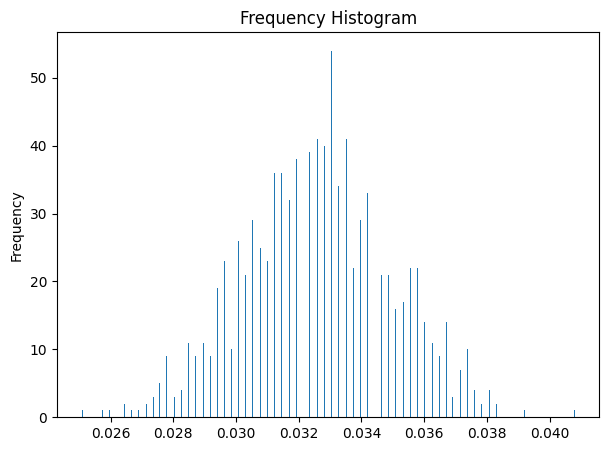

In [64]:
# plot distribution
plt.subplots(figsize=(7,5))
plt.hist(non_stratified_sampled_rates, bins=500)
plt.title("Frequency Histogram")
plt.ylabel("Frequency")
plt.show()

In [65]:
# compare to the overall churn rate
Y.value_counts()[1]/len(Y)

0.032622076323348376

Without stratifying this, you could get a churn rate in your **test set** which can deviate (in some instances) relatively large from the **overall** churn rate. This can be problematic, as you want a test set which does not suffer from sample bias. To overcome this, you should **stratify your train/test sampling**. An even more elaborate solution would be to **cross-validate** the outcome. By making use of multiple train/test splits, the bias towards the test set is minimized, as multiple test sets are considered.

## 4.2. Pre-processing 

We still have to do some pre-processing: **missing value imputation** & **scaling**
    
Why did we not do this earlier on? We first needed to split training and test set, as we want to use NO information from the test set, since we also will have no information about our deployment set. The principle we try to fight here is called **data leakage**.    

### 4.2.1. Missing Value Imputation

In [66]:
# show % of missing values in training set
X_train.isnull().sum()/len(X_train)

complainer             0.000000
incoming               0.000000
LANGUACODE_FR          0.000000
LANGUACODE_NL          0.000000
used_order             0.479922
used_initiative        0.479922
used_sendout           0.479922
used_unknown           0.479922
total_value            0.479922
average_value          0.479922
time_since_purchase    0.479922
frequency              0.479922
dtype: float64

In [67]:
# show % of missing values in test set
X_test.isnull().sum()/len(X_test)

complainer             0.000000
incoming               0.000000
LANGUACODE_FR          0.000000
LANGUACODE_NL          0.000000
used_order             0.466378
used_initiative        0.466378
used_sendout           0.466378
used_unknown           0.466378
total_value            0.466378
average_value          0.466378
time_since_purchase    0.466378
frequency              0.466378
dtype: float64

These are **a lot of missing values**. But due to their nature, we can **assume** that missing corresponds to having no previous transactions. However, to make sure we don't lose the information that this isn't a 'sure' value, we also create a **dummy variable** to indicate that values were missing. However, always solely use information provided in the training set!

In [68]:
# create dummy to indicate whether an observation had a missing value in one of the columns in train/test set
X_train['had_missing'] = X_train.isnull().any(axis=1).astype(int)
X_test['had_missing'] = X_test.isnull().any(axis=1).astype(int)

# show
X_train.head()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
1318,0,1,0,1,1.0,1.0,1.0,1.0,2730.05,20.526692,23 days,133.0,0
1086,0,1,0,1,1.0,0.0,0.0,1.0,2778.07,19.843357,11 days,140.0,0
8662,0,1,1,0,1.0,0.0,1.0,0.0,1960.53,21.544286,11 days,91.0,0
10136,0,1,0,1,1.0,0.0,0.0,0.0,1575.84,65.660000,11 days,24.0,0
9503,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,1


In [69]:
# calculate mean for time_since_purchase
np.mean(X_train['time_since_purchase'])

Timedelta('172 days 02:50:09.581063310')

In [70]:
# Special treatment for time_since_purchase since we'll impute with the mean (using information from the training set) 
# NOTE: we use the mean from the training set for imputation in both the trianing AND the test set!
X_train['time_since_purchase'] = X_train['time_since_purchase'].fillna(np.mean(X_train['time_since_purchase']))
X_test['time_since_purchase'] = X_test['time_since_purchase'].fillna(np.mean(X_train['time_since_purchase']))

# get other column names (train & test have same columns)
other_columns = X_train.columns[X_train.dtypes!='timedelta64[ns]']

# Treatment other variables: no information used from training set ==> same code for train / test set (zero remains zero)
X_train[other_columns] = X_train[other_columns].fillna(value=0)
X_test[other_columns] = X_test[other_columns].fillna(value=0)

# check if we still have missing values in training set
X_train.isnull().sum()

complainer             0
incoming               0
LANGUACODE_FR          0
LANGUACODE_NL          0
used_order             0
used_initiative        0
used_sendout           0
used_unknown           0
total_value            0
average_value          0
time_since_purchase    0
frequency              0
had_missing            0
dtype: int64

In [71]:
# check if we still have missing values in test set
X_test.isnull().sum()

complainer             0
incoming               0
LANGUACODE_FR          0
LANGUACODE_NL          0
used_order             0
used_initiative        0
used_sendout           0
used_unknown           0
total_value            0
average_value          0
time_since_purchase    0
frequency              0
had_missing            0
dtype: int64

### 4.2.2. Scaling

As a final pre-processing step, we will **normalize** the numeric features. This often increases the performance of the model. This also means that we have to make sure that **time differences are in numeric format**.

In [72]:
# check data types
X_train.dtypes

complainer                       int32
incoming                         int32
LANGUACODE_FR                    uint8
LANGUACODE_NL                    uint8
used_order                     float64
used_initiative                float64
used_sendout                   float64
used_unknown                   float64
total_value                    float64
average_value                  float64
time_since_purchase    timedelta64[ns]
frequency                      float64
had_missing                      int32
dtype: object

In [73]:
# convert timedelta64[ns] format to the number of days
X_train['time_since_purchase'] = X_train['time_since_purchase'].dt.days
X_test['time_since_purchase'] = X_test['time_since_purchase'].dt.days

# apply MinMaxScaler on the numeric features (excl. dummies) of the training set:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']])

# NOTE: we apply the scaler that was fitted on the training set to both the train and test set!
X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']] = scaler.transform(X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']])
X_test[['total_value', 'average_value', 'time_since_purchase', 'frequency']] = scaler.transform(X_test[['total_value', 'average_value', 'time_since_purchase', 'frequency']])

In [74]:
# check training set
X_train.describe()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
count,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000,10235.000000
mean,0.047875,0.351930,0.133268,0.866341,0.367269,0.140498,0.311285,0.117049,0.040682,0.120666,0.039829,0.027289,0.479922
std,0.213512,0.477595,0.339881,0.340302,0.482084,0.347520,0.463042,0.321495,0.045818,0.060963,0.088763,0.040370,0.499621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005013,0.087452,0.002546,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.012532,0.115158,0.039815,0.004412,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.078311,0.121770,0.039815,0.047059,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
# check test set
X_test.describe()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
count,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000
mean,0.046729,0.360611,0.137907,0.861865,0.374288,0.144062,0.324823,0.114657,0.041319,0.123200,0.037945,0.027803,0.466378
std,0.211082,0.480232,0.344842,0.345081,0.483994,0.351193,0.468362,0.318644,0.043522,0.065136,0.083138,0.039041,0.498925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004746,0.086796,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005013,0.087452,0.002546,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.014203,0.116585,0.039815,0.005882,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.082743,0.122080,0.039815,0.048529,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.359856,0.543726,1.000000,0.297059,1.000000


## 4.3. Logistic Regression

Next, we will fit a **logistic regression model** onto the training set. 
This model will try to find a relationship between the independent variables and the dependent variable (partial churn)

We are going to fit a logistic regression model with the **following hyperparameters**:
    
        max_iter = 10000

In [76]:
# initialize logistic regression model
lr_model = LogisticRegression(max_iter = 10000)

In [77]:
# fit the model
lr_model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

In [78]:
# get intercept
inter = pd.DataFrame({"Variable": "intercept", "Coefficient": lr_model.intercept_})

# get coefficients
coef = pd.DataFrame({"Variable": X_train.columns, "Coefficient": np.squeeze(lr_model.coef_)})

# join
inter_coef = pd.concat([inter, coef], axis=0)

# check
inter_coef

,Variable,Coefficient
0,intercept,-3.711069
0,complainer,-0.096522
1,incoming,-0.016953
2,LANGUACODE_FR,-0.014941
3,LANGUACODE_NL,0.027605
4,used_order,0.730045
5,used_initiative,1.026276
6,used_sendout,0.084297
7,used_unknown,-0.146645
8,total_value,0.064007


First of all: **assumptions were not checked**, so intepretation is likely (partially) incorrect.
This is of less importance, as we are only interested in getting accurate predictions.

One other side note here: sklearn does not have a built-in functionality to **compute p-values**. 
This is because sklearn is all about predictive modeling, rather than about interpretation of effects.
This suits us, as we want to predict churn behavior as reliable as possible.
Afterwards, we will use a method that is more advanced than logistic regression (i.e., random forest).
Such a model is much harder to interpret and does not give p-values anyway. The advantage is that their predictive power is often higher. Sklearn implements a lot of these types of algorithms.

We can however interpret the nature of the relationships without knowing their statistical significance.

**Recency** (time_since_purchase) has a negative effect on churn. The longer it has been since one has donated, the less likely churn becomes. This as opposed to what one might expect. The underlying contractual relationship probably is at the cause of this.
A more logical relationship holds for **frequency** (or total_value). If a donor has already donated often (or a lot), it is more likely he/she will keep doing this.
Also the effect of **preferred language** can be seen in line with expectations. The reference category was English. So people with French or Dutch are less likely to churn than English speakers. Since the data is about a Belgian non-profit, it seems plausible that keeping in contact is a lot of effort for non-Belgian donators.

Other insights are more surprising. Being a **complainer** has nearly no impact on churn probability. Issuing **incoming communication** has a much greater effect. Perhaps complaint is incorrectly classified in the organization's system and is every form of incoming communication actually a signal there is something wrong.

## 4.4. Random Forest

Our explanation of the recency-churn relationship clearly hints towards a non-linear relationship, so will also try out a non-linear model which is known for its good predictive performance: **random forest**

We are going to fit a random forest model with the **following hyperparameters**:
    
        n_estimators = 500

In [79]:
# initialize random forest model with 500 trees
rf_model = RandomForestClassifier(n_estimators=500)

# fit the model
rf_model.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=500)

But how to **interpret** such a model? This cannot be done by default, one needs to deploy techniques from the field from **explainable artificial intelligence (XAI)**. But before doing so, let us **evaluate** which model performs best

# 5. Evaluation

Evaluate your model with **two methods**:

   
    1. Compute following statistics based on the threshold of 0.20:
    
        true positive
        false positive
        true negatives
        false negatives
        accuracy
        recall
        precision
    
    2. Compute the ROC-curve and according AUC

Hint: You have to compute the outcomes (predictions) of your model before you can them. 
Hint2: At the top of the notebook we already imported the necessary functions.

The **measures from 1**. are all based on the **confusion matrix**, so perhaps compute that first (always check out the documentation). For more information: check out Wikipedia: https://en.wikipedia.org/wiki/Confusion_matrix

The **measures in 2**. are then computed based on the **ROC-curve**. The ROC-curve plots the false positive rate and true positive rate against different thresholds, while in 1., we just checked for one threshold. The **AUC** is basically just the integral of the ROC-curve and is generally regarded as a very complete measure for the evaluation of classification algorithms. 

In [80]:
# make predictions
predictions = lr_model.predict(X_test) # this is what we would do if we would use a simple threshold of 0.5
pred_probabilities_lr = lr_model.predict_proba(X_test) # we actually need the probabilities, to target the 20% most probable churners

In [81]:
# the first column is probability of non-churn (=0), the second column is the probability of churn (=1)
pred_probabilities_lr

array([[0.9967094, 0.0032906],
       [0.9967094, 0.0032906],
       [0.9967094, 0.0032906],
       ...,
       [0.9236739, 0.0763261],
       [0.940855 , 0.059145 ],
       [0.9967094, 0.0032906]])

In [82]:
# select only the probabilities to churn (=1)
churn_prob = pred_probabilities_lr[:,1]

For ease of interpretation we will first start with **non-flexible code**. Afterwards, this will be combined into 1 flexible code where you can change the tresholds.

In [83]:
# create data frame with probabilities and actual outcome
evaluation_frame_lr = pd.concat([pd.Series(churn_prob.reshape(len(Y_test))), Y_test.reset_index(drop=True)], axis = 1)
evaluation_frame_lr.columns = ["probabilty", "actual_outcome"] # rename columns

In [84]:
# show
evaluation_frame_lr.head()

,probabilty,actual_outcome
0,0.003291,0
1,0.003291,0
2,0.003291,0
3,0.076583,0
4,0.078098,0


In [85]:
# now we'll order by probabilty
evaluation_frame_lr = evaluation_frame_lr.sort_values(by=['probabilty'], ascending = False)

# show
evaluation_frame_lr.head()

,probabilty,actual_outcome
2984,0.156230,1
2102,0.153194,0
2765,0.151459,0
60,0.151307,0
115,0.150851,0


In [86]:
# we only want to have highest N (=0.20 of total) probabilties (i.e. most likely churners)
highest_prob = evaluation_frame_lr.nlargest(round((0.2*len(evaluation_frame_lr))), ['probabilty'])['probabilty']

# we contact them all, thus we assume them all to be churners
evaluation_frame_lr['expected_outcome'] = np.where(evaluation_frame_lr['probabilty'].isin(highest_prob), 1, 0)

# now compute the necessary values
accuracy = accuracy_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
precision = precision_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
recall = recall_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
tn, fp, fn, tp = confusion_matrix(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome']).ravel()

# print output
print("true positives: %s" %tp)
print("false positive: %s" %fp)
print("true negatives: %s" %tn)
print("false negatives: %s" %fn)
print("accuracy: %s" %accuracy)
print("recall: %s" %recall)
print("precision: %s" %precision)

true positives: 65
false positive: 812
true negatives: 3432
false negatives: 78
accuracy: 0.7971278778208343
recall: 0.45454545454545453
precision: 0.07411630558722919


The results could be better. We are correct in 80% of the cases (i.e. accuracy). But this **due to a lot of non-churners** in the dataset and we assume 80% to be non-churners. When we look at the other measures, results are much less positive. 

**Precision** stands for True Positive/(True Positive + False Positive) and actually means how precise you have predicted your class (here: churners). The value of 0.07 means that only 7% of the people we contacted were churners. This isn't surprising, given the limited number of churners in the data.

Another interesting measure is **recall**. It is computed by True Positive/(True Positive + False Negative). It actually stands for the percentage of your class you have identified. This means that our campaign was able to contact 43% of churners by contacting only 20% of customers. 

So, while our model isn't perfect, we are clearly capable of **doing better than randomly contacting donors**.

Interesting to see, is how **different percentages** affect the effectiveness of our campaign. To do so, we have to make our code flexible.

In [87]:
# create function to take X% highest ranked probabilities and compare against actual values
def evaluation_function(threshold, evaluation_frame):
    # retrieve N most likely churners
    highest_prob = evaluation_frame.nlargest(round((threshold*len(evaluation_frame))), ['probabilty'])['probabilty']

    # we contact them all, thus we assume them all to be churners
    evaluation_frame['expected_outcome'] = np.where(evaluation_frame['probabilty'].isin(highest_prob), 1, 0)

    # now compute the necessary values
    accuracy = accuracy_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    precision = precision_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    recall = recall_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    tn, fp, fn, tp = confusion_matrix(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome']).ravel()
    
    # print output
    print("true positives :%s" %tp)
    print("false positive: %s" %fp)
    print("true negatives: %s" %tn)
    print("false negatives: %s" %fn)
    print("accuracy: %s" %accuracy)
    print("recall: %s" %recall)
    print("precision: %s" %precision)

In [88]:
# use function with top 15% most likely churners labeled as churners
evaluation_function(0.15, evaluation_frame_lr)

true positives :56
false positive: 602
true negatives: 3642
false negatives: 87
accuracy: 0.8429450649646684
recall: 0.3916083916083916
precision: 0.0851063829787234


In [89]:
# use function with top 10% most likely churners labeled as churners
evaluation_function(0.10, evaluation_frame_lr)

true positives :39
false positive: 400
true negatives: 3844
false negatives: 104
accuracy: 0.8851151128333713
recall: 0.2727272727272727
precision: 0.0888382687927107


In [90]:
# use function with top 25% most likely churners labeled as churners
evaluation_function(0.25, evaluation_frame_lr)

true positives :77
false positive: 1020
true negatives: 3224
false negatives: 66
accuracy: 0.7524504217004787
recall: 0.5384615384615384
precision: 0.07019143117593436


Up to you to play around and decide which is the **optimal threshold**. 

Let's apply our function on the **random forest algorithm**. Given our used methodology, we need to first create an 'evaluation frame' for this algorithm as well.

In [91]:
# get probabilities
pred_probabilities_rf = rf_model.predict_proba(X_test)

# select probabilities of whether someone will churn (=1)
churn_prob_rf = pred_probabilities_rf[:,1]

# evaluation frame to compare prediction with actual outcome
evaluation_frame_rf = pd.concat([pd.Series(churn_prob_rf.reshape(len(Y_test))), Y_test.reset_index(drop=True)], axis = 1)
evaluation_frame_rf.columns = ["probabilty", "actual_outcome"]

# sort values
evaluation_frame_rf = evaluation_frame_rf.sort_values(by=['probabilty'], ascending = False)

# use evaluation function with top 20% most likely churners labeled as churners
evaluation_function(0.2, evaluation_frame_rf)

true positives :80
false positive: 811
true negatives: 3433
false negatives: 63
accuracy: 0.8007750170959653
recall: 0.5594405594405595
precision: 0.08978675645342311


Remarkable: both **recall** AND **precision** score better. But this may be **threshold dependent**. We are now going to compute the **AUC** as this is an objective performance measure on how well the algorithm performs, regardless of thresholds (i.e. **threshold independent**). A value of 0.5 corresponds to randomly contacting people and 1 corresponds to only contacting the right people.

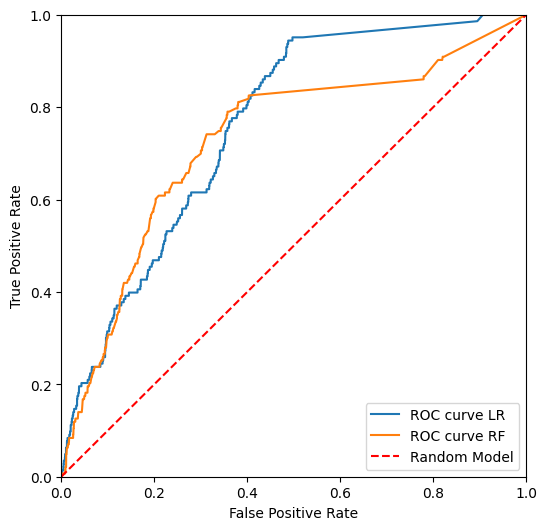

In [92]:
# compute ROC curve for logistic regression (LR)
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(Y_test, churn_prob)

# compute ROC curve for random forest (RF)
false_positive_rate_rf, true_positive_rate_rf, threshold_rf = roc_curve(Y_test, churn_prob_rf)

# plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate_lr, true_positive_rate_lr, label='ROC curve LR') # plot curve LR
plt.plot(false_positive_rate_rf, true_positive_rate_rf, label='ROC curve RF') # plot curve RF
plt.plot([0, 1], [0, 1],'r--', label='Random Model') # plot what randomly saying 0 or 1 would do (=diagonal)
plt.legend(loc='lower right') #plot legend
plt.xlim([0, 1]) 
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This is remarkable! While the **random forest** algorithm performs much better at 'common' thresholds, we also observe a drop in performance at much lower thresholds, the algorithm struggles heavily to identify the last churners in the test set, while the **logistic regression** is capable of detecting all churners (reaching upper part curve) at much lower thresholds. Let us use our **evaluation** function in these ranges:

In [93]:
# evaluate logistic regression model at 50% threshold
evaluation_function(0.5, evaluation_frame_lr)

true positives :133
false positive: 2061
true negatives: 2183
false negatives: 10
accuracy: 0.5279234100752223
recall: 0.9300699300699301
precision: 0.060619872379216046


In [94]:
# evaluate random forest model at 50% threshold 
evaluation_function(0.5, evaluation_frame_rf)

true positives :123
false positive: 3303
true negatives: 941
false negatives: 20
accuracy: 0.24253476179621608
recall: 0.8601398601398601
precision: 0.03590192644483362


Our plot-based observations are confirmed. How would this translate into **AUC**?

In [95]:
# compute AUC for LR model
roc_auc_score(Y_test, churn_prob)

0.7591260059450445

In [96]:
# compute AUC for RF model
roc_auc_score(Y_test, churn_prob_rf)

0.7284969978183928

Logistic regression is identified as better with regard to AUC. So which algorithm to select? Normally, the reaction would be to select the **best AUC score** (i.e., LR), but you have to think about your marketing campaign objectives! You will only contact the top N% of customers, and RF performs better in those situations! So we will use RF nonetheless, only for overly large churn campaigns (contacting half of the customer base), would the LR model be better But think about how expensive such a campaingn would be. When evaluating models, always think about different **evaluation metrics** and how they relate to your **business goals**

## 6. Interpretation Random Forest

As we want use the random forest model, we would also like some insights into the drivers behind the algorithm.

In [97]:
# install the shap package
#!pip install shap

In [98]:
# import shap package
import shap
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.Explainer(rf_model)

# get SHAP values
shap_values = explainer.shap_values(X_test)

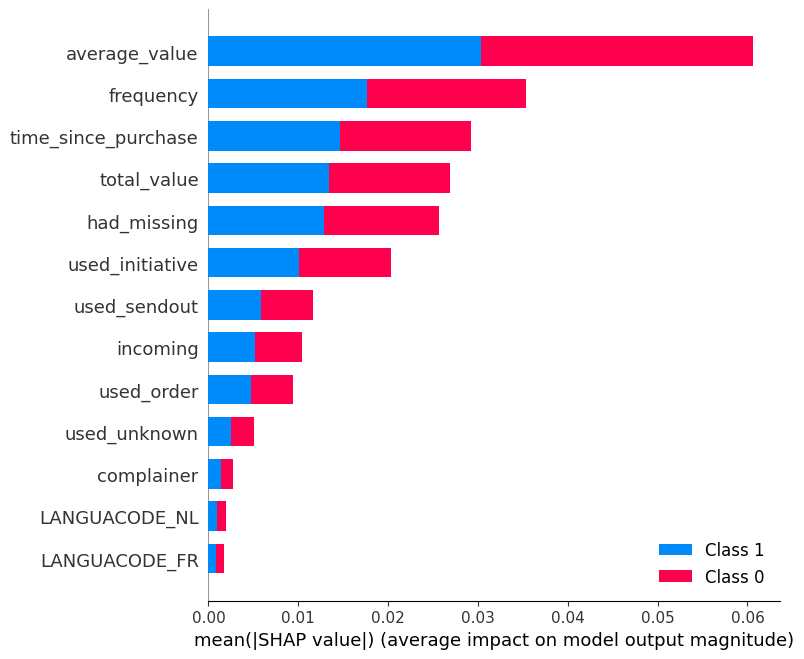

In [100]:
# get summary plot
shap.summary_plot(shap_values, X_test)

Notice how long this takes to compute. You should only do such computationally expensive calculations after selection of the final model. For interpretation of intermediate results, try to use quick and easy solutions such a **partial dependence plots**. A solution could lay in using ```shap_values = explainer.shap_values(explanation_sample)```, with ```explanation_sample = X_test.iloc[0:N,:]```, with **N** being a sufficiently large sample size (e.g., 500) Note that you then also should input explanation_sample instead of X_test at later code fragments.

Let us quickly run over how you can calculate this yourself:

In [101]:
# get variable importance (using mean absolute SHAP values)
shap_df = pd.DataFrame(np.average(abs(shap_values[0]),axis=0), X_test.columns)

# sort according to importance
shap_df.sort_values(by=0, ascending = False)

,0
average_value,0.030295
frequency,0.017679
time_since_purchase,0.014636
total_value,0.013449
had_missing,0.012849
used_initiative,0.010133
used_sendout,0.005805
incoming,0.005226
used_order,0.004730
used_unknown,0.002527


In [102]:
# compare with our results from our logistic regression model
inter_coef['abs_coef'] = abs(inter_coef['Coefficient'])
inter_coef.sort_values(by = 'abs_coef', ascending = False)

,Variable,Coefficient,abs_coef
0,intercept,-3.711069,3.711069
12,had_missing,-2.029327,2.029327
10,time_since_purchase,-1.943465,1.943465
5,used_initiative,1.026276,1.026276
9,average_value,0.874310,0.874310
4,used_order,0.730045,0.730045
7,used_unknown,-0.146645,0.146645
0,complainer,-0.096522,0.096522
6,used_sendout,0.084297,0.084297
11,frequency,-0.079017,0.079017


In [103]:
# more information on dependence plot
help(shap.dependence_plot)

Help on function dependence_legacy in module shap.plots._scatter:

dependence_legacy(ind, shap_values=None, features=None, feature_names=None, display_features=None, interaction_index='auto', color='#1E88E5', axis_color='#333333', cmap=None, dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True, ymin=None, ymax=None)
    Create a SHAP dependence plot, colored by an interaction feature.
    
    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of the classical parital dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.
    
    
    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the

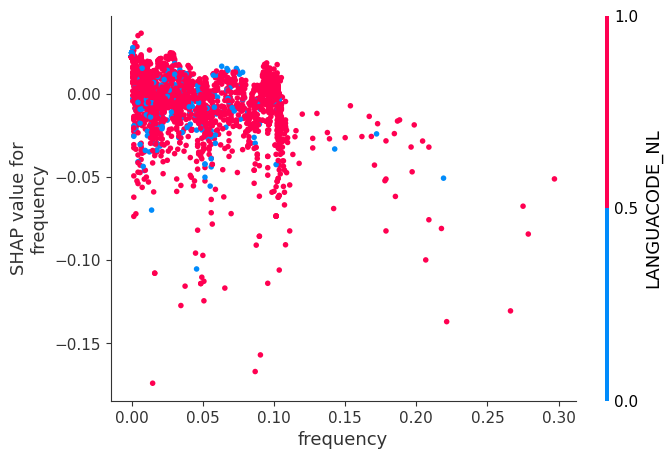

In [104]:
# dependence plot for frequency
selected_col = X_test.columns.get_loc('frequency')
shap.dependence_plot(selected_col, shap_values[0], X_test)

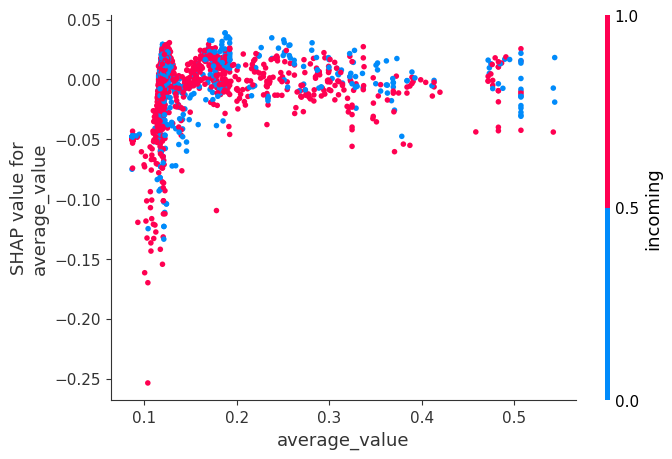

In [105]:
# dependence plot for average_value
selected_col = X_test.columns.get_loc('average_value')
shap.dependence_plot(selected_col, shap_values[0], X_test)

Especially the **average_value** plot hints towards a non-linear relationship which could not be captured by the logistic regression model.

A large advantage of the SHAP framework is the fact that it can be use to explain **individual predictions**. This can be really helpful for the managers deploying the product: is this the right reason for us to contact or not contact this customer? The customer below (**customer 420**) has a rather high predicted probability to churn compared to **customer 280**. Mainly because of the observed frequency and average value of customer 420. Note how **scaling** makes the interpretation of these numbers more difficult. In fact, **when deploying tree-based models**, it might be better to not deploy scaling, as their splitting mechanism makes them robust to outliers anyway. It is important to know all the advantages and disadvantages of each algorithm and how this translates towards interpretability/predictive performance.

In [106]:
# choose customer 420
chosen_instance = X_test.iloc[420,:]

# get shap values
shap_values_spec = explainer.shap_values(chosen_instance)

# how does each variable contribute to this specific prediction ==> force plot
shap.force_plot(explainer.expected_value[1], shap_values_spec[1], chosen_instance)

In [107]:
# choose customer 280
chosen_instance = X_test.iloc[280,:]

# get shap values
shap_values_spec = explainer.shap_values(chosen_instance)

# how does each variable contribute to this specific prediction ==> force plot
shap.force_plot(explainer.expected_value[1], shap_values_spec[1], chosen_instance)